# AMLD 2021

> ##### Machine Learning in Science: Encoding physical constraints and good development practices


## Example 04 - Physics "embedding" through the neural network

In this notebook, we demonstrating a method for ensuring physical consistency of the predictions by incoorporating knownledge in the neural network

### Workshop Organizers

* Dr. Maria Han Veiga (University of Michigan, USA)

* Dr. Miles Timpe (University of Zurich, Switzerland)

### Import libraries

In [1]:
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import r2_score


# Global seed value
seed = 42

# Set random seeds
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)


# Versions can also influence reproducibility
from sys import version
print(f"Python version: {version}")

Python version: 3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


### Load test data and scalers

We focus first on lr_mass.

In [9]:
target = 'lr_mass'

features = ['mtotal', 'gamma', 'b_inf', 'v_inf',
            'targ_core_fraction', 'targ_omega', 'targ_theta', 'targ_phi',
            'proj_core_fraction', 'proj_omega', 'proj_theta', 'proj_phi',
            target]

x_train = pd.read_csv('../datasets/train.csv', usecols=features)
x_test  = pd.read_csv('../datasets/test.csv', usecols=features)

y_train = x_train.pop(target)
y_test  = x_test.pop(target)

# Load scalers and scale targets
scalers = {}
data = {}

y_scaler = load(f"../models/y_scaler_{target}.joblib")

scaled_y_train = y_scaler.transform(y_train.values.reshape(-1, 1))
scaled_y_test  = y_scaler.transform(y_test.values.reshape(-1, 1))
    
# Scale features
x_scaler = load(f"../models/x_scaler.joblib")

scaled_x_train = pd.DataFrame(x_scaler.transform(x_train), columns=x_train.columns)
scaled_x_test = pd.DataFrame(x_scaler.transform(x_test), columns=x_test.columns)

### Setup physics informed neural network

Here, we will first focus on the 'lr_mass' target

In [52]:
# Define model (MLP) using Keras
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Subtract, Lambda, add, ReLU
from keras.callbacks import EarlyStopping

target = 'lr_mass'

_, input_size = scaled_x_train.shape

# load previously trained model
model_uninformed = keras.models.load_model(f"../models/regressor_mlp_{target}.keras")

In [35]:
input1 = keras.layers.Input(shape=(16,))
x1 = keras.layers.Dense(8, activation='relu')(input1)
input2 = keras.layers.Input(shape=(32,))
x2 = keras.layers.Dense(8, activation='relu')(input2)
# Equivalent to subtracted = keras.layers.subtract([x1, x2])
subtracted = keras.layers.Subtract()([x1, x2])

out = keras.layers.Dense(4)(subtracted)
model = keras.models.Model(inputs=[input1, input2], outputs=out)


In [98]:

r1 = Input(shape=(10,12))
r2 = Input(shape=(10,12))

# Lambda for subtracting two tensors
#minus_r2 = Lambda(lambda x: -x)(r2)
#subtracted = 
r3 =  tf.gather(r1,[0],axis=2)
r4 =  tf.gather(r2,[0],axis=2)
out= Lambda(lambda x: x)(Subtract()([r3,r4]))

model = keras.Model([r1,r2],out)

a = np.arange(120).reshape([1,10,12])
b = np.ones(120).reshape([1,10,12])

print(model.predict([a,b]))
# [[[[ 1.  0.]
#    [ 1.  4.]]]]

print(a[:,0]-b[:,0])
#print((a-b))
# [[[[ 1.  0.]
#    [ 1.  4.]]]]

print(a)
print(b)

[[[ -1.]
  [ 11.]
  [ 23.]
  [ 35.]
  [ 47.]
  [ 59.]
  [ 71.]
  [ 83.]
  [ 95.]
  [107.]]]
[[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]]
[[[  0   1   2   3   4   5   6   7   8   9  10  11]
  [ 12  13  14  15  16  17  18  19  20  21  22  23]
  [ 24  25  26  27  28  29  30  31  32  33  34  35]
  [ 36  37  38  39  40  41  42  43  44  45  46  47]
  [ 48  49  50  51  52  53  54  55  56  57  58  59]
  [ 60  61  62  63  64  65  66  67  68  69  70  71]
  [ 72  73  74  75  76  77  78  79  80  81  82  83]
  [ 84  85  86  87  88  89  90  91  92  93  94  95]
  [ 96  97  98  99 100 101 102 103 104 105 106 107]
  [108 109 110 111 112 113 114 115 116 117 118 119]]]
[[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1.

In [ ]:
# Define model (MLP) using Keras
from keras import backend as K
import tensorflow as tf
import sys

def custom_loss_wrapper(input_tensor, overshoot_weight=0.0):
    def custom_loss(y_true,y_pred):
        s = tf.gather(input_tensor,[0],axis=1)
        #s = tf.print(s, [s], "shape",output_stream=sys.stdout)
        s = Lambda(lambda x: x)(s)
        #overshoot = K.sum(ReLU()(Lambda(lambda x: -x)(Subtract()([s1,y_pred]))))
        #print(K.sum(overshoot).eval())
        #d = tf.print(overshoot, [overshoot], "Inside loss function",output_stream=sys.stdout)
        return keras.losses.mean_squared_error(y_true, y_pred) #+ overshoot
    return custom_loss

batchsize=128
inputs = Input(shape=(input_size,))
f = Dense(24,activation='relu')(inputs)
f = Dense(24,activation='relu')(f)
f = Dense(24,activation='relu')(f)
outputs = Dense(1)(f)

model = keras.Model(inputs, outputs)

model.compile('Adam', loss=custom_loss_wrapper(inputs), metrics="mse")

# Fit model
model.fit(x_train, y_train, validation_split = 0.05, epochs=100, callbacks=[EarlyStopping(patience=70)],verbose=0)

# Make predictions
y_pred = model.predict(x_test)

# Apply inverse scaling to the model predictions
#y_scaler = load(f"../models/y_scaler_{target}.joblib")

#y_pred = pd.Series(y_scaler.inverse_transform(scaled_y_pred.flatten()), name='y_pred').values

# Calculate the quality of the predictions with the r2 score
r2 = r2_score(y_test, y_pred)


# Save the model with keras
model.save(f"../models/regressor_mlp_customloss_{target}.keras")

print(f"Prediction r2_score: {r2:.4f}")

### Plot: mass residual histogram

In order to get an idea of how bad the uncoupled models are at conserving mass, we plot a histogram of the mass residuals. The residuals are simply the difference in predicted final total mass vs the true initial total mass. The range of total mass is large, so we plot the normalized mass residuals to account for this.

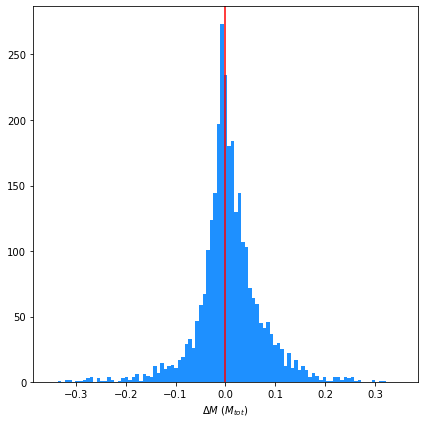

In [6]:
def mass_residual(row):
    # Calculate the normalized mass residual
    
    dM = row['m_tot'] - row['lr_mass'] - row['slr_mass'] - row['debris_mass']
    
    return dM / row['m_tot']


data['residual'] = data.apply(mass_residual, axis=1)


# Histogram
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.set_xlabel(r'$\Delta M$ $(M_{tot})$')

ax.hist(data.residual, bins=np.linspace(-0.35, 0.35, num=100),
        color='dodgerblue')

ax.axvline(x=0, color='red', alpha=1)

plt.tight_layout()

### Physical constraints: mass conservation

From the r2 scores reported above, it's clear that the predictions of the SLR (second largest remnant) mass are significantly worse than the predictions for the other targets. 

In [7]:
def best_two(row):    
    # We use the most accurate two regressors and the third is replaced by the residual.
    
    # Ensure no negative masses
    m_lr = np.max([0.0, row['lr_mass']])
    m_slr = np.max([0.0, row['slr_mass']])
    m_deb = np.max([0.0, row['debris_mass']])
    
    
    if m_lr >= row['m_tot']:
        
        return row['m_tot'], 0.0, 0.0
    
    elif m_lr + m_deb > row['m_tot']:
        
        return m_lr, 0.0, row['m_tot'] - m_lr
    
    else:

        m_slr = row['m_tot'] - m_lr - m_deb

        return m_lr, m_slr, m_deb


data[['lr_pred', 'slr_pred', 'debris_pred']] = data.apply(best_two, axis=1, result_type="expand")

In [8]:
def new_residual(row):
    # Calculate the normalized mass residual
    
    dM = row['m_tot'] - row['lr_pred'] - row['slr_pred'] - row['debris_pred']
    
    return dM / row['m_tot']


data['new_residual'] = data.apply(new_residual, axis=1)


print(f"deltaM min = {data.new_residual.min()}")
print(f"deltaM max = {data.new_residual.max()}")

deltaM min = -5.332263554372243e-17
deltaM max = 4.279851668516389e-17


In [ ]:
# Histogram
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.set_xlabel(r'$\Delta M$ $(M_{tot})$')

ax.hist(data.residual, bins=np.linspace(-0.35, 0.35, num=100),
        color='dodgerblue')

ax.axvline(x=0, color='red', alpha=1)

plt.tight_layout()

In [9]:
print(f"{'Mass':>8}{'Unconstrained':>22}{'Constrained':>18}")

for name in targets:
    
    name = name.split('_')[0]
    
    # Load true values
    y_test = data[f"{name}_true"]
    y_pred = data[f"{name}_mass"]
    y_phys = data[f"{name}_pred"]
    
    # Calculate the quality of the predictions with the r2 score
    r2_pred = r2_score(y_test, y_pred)
    r2_phys = r2_score(y_test, y_phys)
    
    
    print(f"{name:>8}{r2_pred:>15.4f}{r2_phys:>20.4f}")

    Mass         Unconstrained       Constrained
      lr         0.9881              0.9886
     slr         0.9575              0.9320
  debris         0.9921              0.9925


### Comments

As we can see from the results above, we have traded a bit of accuracy in return for obeying physics. 

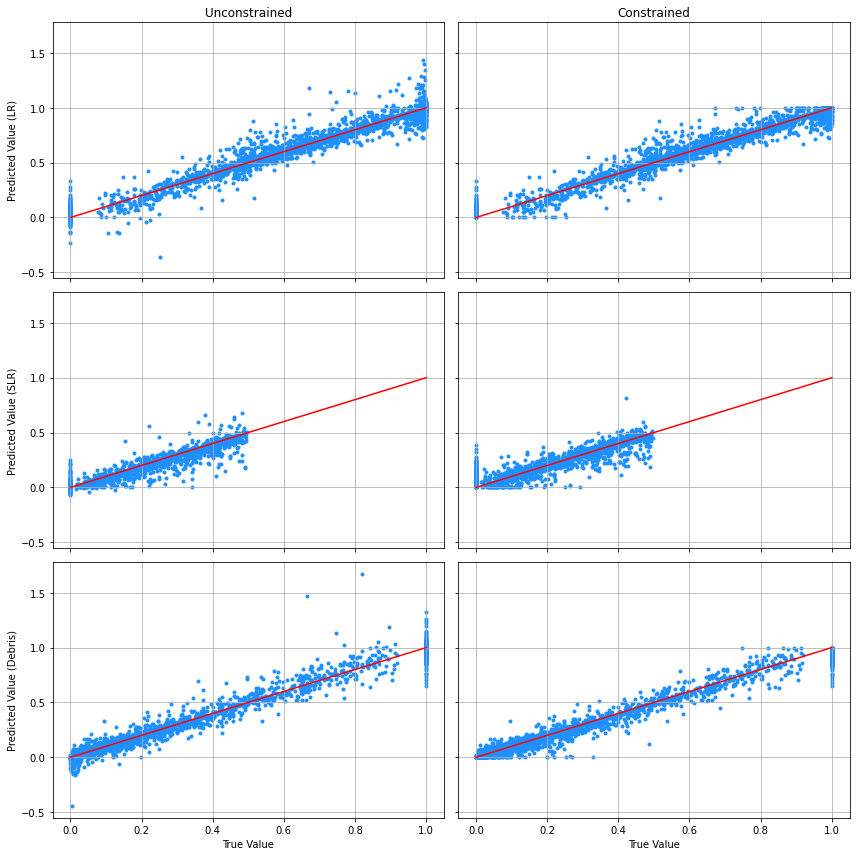

In [10]:
fig1, ax1 = plt.subplots(3, 2, figsize=(12,12), sharex=True, sharey=True)



# LR
y_test_norm = []
y_pred_norm = []
y_phys_norm = []

for m_tot, y_t, y_p, y_c in zip(x_test.mtotal, data.lr_true, data.lr_mass, data.lr_pred):
    y_test_norm.append( y_t / m_tot )
    y_pred_norm.append( y_p / m_tot )
    y_phys_norm.append( y_c / m_tot )
    
    
ax = ax1[0][0]

ax.set_title('Unconstrained')
ax.set_ylabel('Predicted Value (LR)')

ax.grid(True)

ax.scatter(y_test_norm, y_pred_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')


ax = ax1[0][1]

ax.set_title('Constrained')


ax.grid(True)

ax.scatter(y_test_norm, y_phys_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')



# SLR
y_test_norm = []
y_pred_norm = []
y_phys_norm = []

for m_tot, y_t, y_p, y_c in zip(x_test.mtotal, data.slr_true, data.slr_mass, data.slr_pred):
    y_test_norm.append( y_t / m_tot )
    y_pred_norm.append( y_p / m_tot )
    y_phys_norm.append( y_c / m_tot )
    
    
ax = ax1[1][0]

ax.set_ylabel('Predicted Value (SLR)')

ax.grid(True)

ax.scatter(y_test_norm, y_pred_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')


ax = ax1[1][1]

ax.grid(True)

ax.scatter(y_test_norm, y_phys_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')



# Debris
y_test_norm = []
y_pred_norm = []
y_phys_norm = []

for m_tot, y_t, y_p, y_c in zip(x_test.mtotal, data.debris_true, data.debris_mass, data.debris_pred):
    y_test_norm.append( y_t / m_tot )
    y_pred_norm.append( y_p / m_tot )
    y_phys_norm.append( y_c / m_tot )
    
    
ax = ax1[2][0]

ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value (Debris)')

ax.grid(True)

ax.scatter(y_test_norm, y_pred_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')


ax = ax1[2][1]

ax.set_xlabel('True Value')

ax.grid(True)

ax.scatter(y_test_norm, y_phys_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')


plt.tight_layout()